In [ ]:
import numpy as np, torch, time
from Ctubes.curve_parametrizations import trefoil_parameterization
from Ctubes.geometry_utils import (
    rotate_about_axis, regular_polygon, 
    compute_binormals, get_bisecting_plane_normals_with_symmetry
)
from Ctubes.plot_utils import plot_generatrix
from Ctubes.tubes import Directrix, Generatrix, CTube
from Ctubes.opt import CTubeOptimizationProblem
from Ctubes.misc_utils import get_pairings_exact
from Ctubes.path_utils import get_name, setup_paths

paths = setup_paths(get_name())

PI = np.pi
TORCH_DTYPE = torch.float64
torch.set_default_dtype(TORCH_DTYPE)
torch.set_printoptions(precision=4)

%load_ext autoreload
%autoreload 2

%matplotlib widget

# Figure 19: Fodable Accordion Trefoil

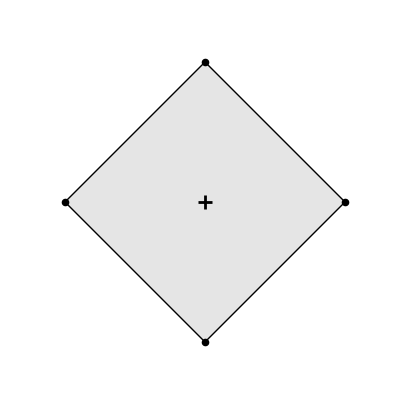

In [3]:
# Generatrix: regular N-gon
N = 4
tube_radius = 0.3
generatrix_2d = regular_polygon(N, tube_radius)

fig, ax = plot_generatrix(generatrix_2d)

In [4]:
# DIrectrix: coarse trefoil knot with binormal offsets 
closed_curve = True
K_per_lobe = 12
n_fold_symm = 3
K = K_per_lobe * n_fold_symm + 1
M = K

# Define the spline
ts_disc_curve = torch.linspace(0.0, 2.0 * PI, K)
cps_ref = trefoil_parameterization(ts_disc_curve)

# z-scale
cps_ref[:, 2] *= 1.5

# Offset points along +/- the curve binormal
binormals = compute_binormals(cps_ref)
offset_dir = binormals
offset_dir[1::2] = -offset_dir[1::2]
offset_dir *= 0.8 * tube_radius
cps_ref[1:K_per_lobe] += offset_dir[1:K_per_lobe]
cps_ref[-1] = cps_ref[0]

In [5]:
# Define symmetry transforms
z_axis = torch.tensor([0.0, 0.0, 1.0], dtype=TORCH_DTYPE)
symm_3_fold = [
    lambda pts: rotate_about_axis(pts, z_axis, torch.tensor(4*PI/3)),
    lambda pts: rotate_about_axis(pts, z_axis, torch.tensor(8*PI/3)),
]
symmetry_transforms = symm_3_fold

# Select one third of the curve
K = (K - 1) // n_fold_symm + 1
M = (M - 1) // n_fold_symm + 1
cps_ref = cps_ref[:K]

In [6]:
# C-tube
directrix = Directrix(cps_ref, M, symmetry_transforms=symmetry_transforms)

X0 = directrix.X[0]
T0 = directrix.get_tangents()[0]
generatrix = Generatrix(generatrix_2d, X0, T0)


plane_normals = get_bisecting_plane_normals_with_symmetry(directrix)

tube = CTube(
    directrix, generatrix, plane_normals,
    symmetry_transforms=symmetry_transforms
)

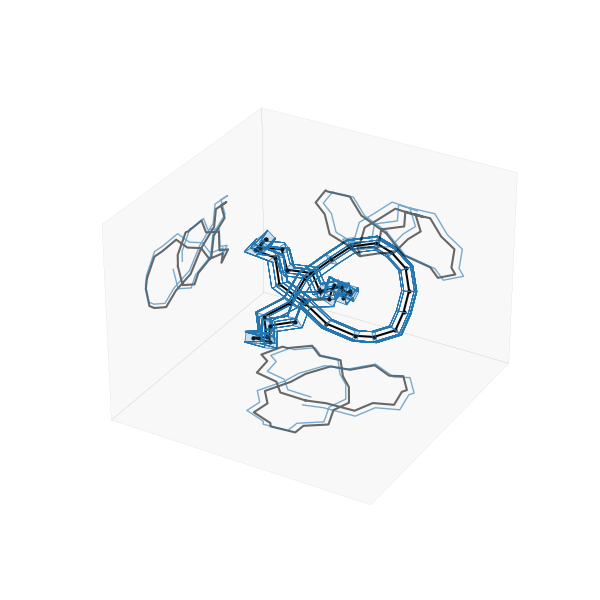

In [7]:
fig, ax = tube.plot_3d()

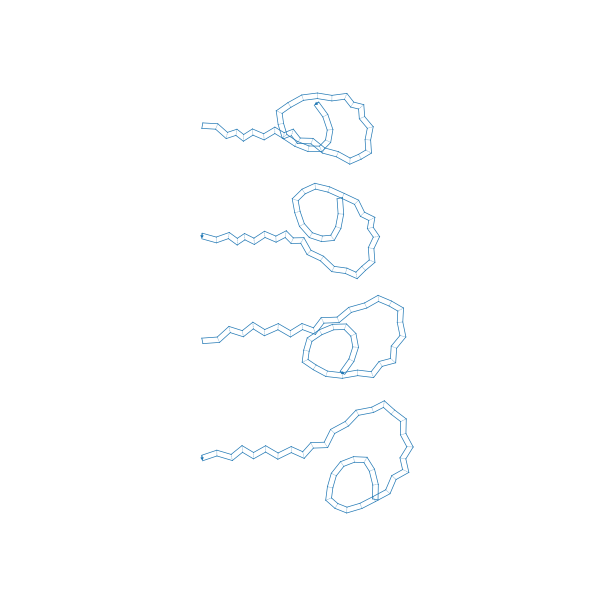

In [8]:
fig, ax = tube.plot_unrolled_strips()

### Optimization

In [9]:
# Set up optimization problem

opt_weights = {
    'preserve_curve': 1e-2 / directrix.aabb_diagonal_length() ** 2,
    'join_ends': 1.0 / generatrix.aabb_diagonal_length() ** 2,
}

objective_args = {
    'join_ends_pairings': get_pairings_exact(N),
}

opt_prob = CTubeOptimizationProblem(
    tube, 
    opt_weights, 
    objective_args,
)

opt_prob.activate_cps(True)
opt_prob.activate_theta(False)
opt_prob.activate_apex_loc_func(False)
opt_prob.activate_plane_normals(False)

In [10]:
opt_prob.opt_weights['smooth_plane_normal_diffs'] = 0.0  # deactivate plane normal smoothing

In [11]:
opt_prob.compute_objective(print_to_console=True)

preserve_curve                          : 0.0000000000
join_ends                               : 0.2396014517
smooth_plane_normal_diffs               : 0.0000000000
preserve_tube_ridge_edge_directions     : 0.0000000000


tensor(0.2396)

In [12]:
from scipy.optimize import minimize
from Ctubes.opt import obj_and_grad

torch.autograd.set_detect_anomaly(False)

# Set up optimization configuration
opt_prob.configure_optimization_output(paths)

# Get initial parameters
params0 = opt_prob.get_params_numpy()

# Define objective and gradient function for SciPy
obj_and_grad_scipy = lambda params: obj_and_grad(params, opt_prob)

# Fix variables via double-sided bounds
fixed_indices = []
dofs = opt_prob.get_dof_indices_cps()
fixed_indices += dofs[:3] + dofs[-3:]  # fix endpoints
fixed_indices = list(set(fixed_indices))  # remove duplicates
fixed_indices = sorted(fixed_indices)

bounds = [(None, None)] * len(params0)
for idx in fixed_indices:
    bounds[idx] = (params0[idx], params0[idx])
print(f"Fixing {len(fixed_indices)} parameters.")

# Add initial state to history
opt_prob.add_objective_to_history()

Fixing 6 parameters.


In [13]:
# Run optimization
start_time = time.time()
result = minimize(
    obj_and_grad_scipy, 
    params0, 
    jac=True, 
    method='L-BFGS-B',
    options={'ftol': 1.0e-10, 'gtol': 1.0e-5, 'disp': True, 'maxiter': 2000},
    bounds=bounds,
    callback=opt_prob.optimization_callback,
)
result.execution_time = time.time() - start_time

# Finalize optimization (save results, render videos, cleanup)
opt_prob.finalize_optimization(result)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           39     M =           10

At X0         6 variables are exactly at the bounds

At iterate    0    f=  2.39601D-01    |proj g|=  1.38146D-01

At iterate    1    f=  1.71650D-04    |proj g|=  1.89371D-02

At iterate    2    f=  3.90406D-06    |proj g|=  5.27610D-04

At iterate    3    f=  3.77666D-06    |proj g|=  6.18322D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   39      3      5      3     0     6   6.183D-06   3.777D-06
  F =   3.7766609549546267E-006

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [14]:
opt_prob.compute_objective(print_to_console=True)

preserve_curve                          : 0.0000037767
join_ends                               : 0.0000000000
smooth_plane_normal_diffs               : 0.0000000000
preserve_tube_ridge_edge_directions     : 0.0000000000


tensor(3.7767e-06)

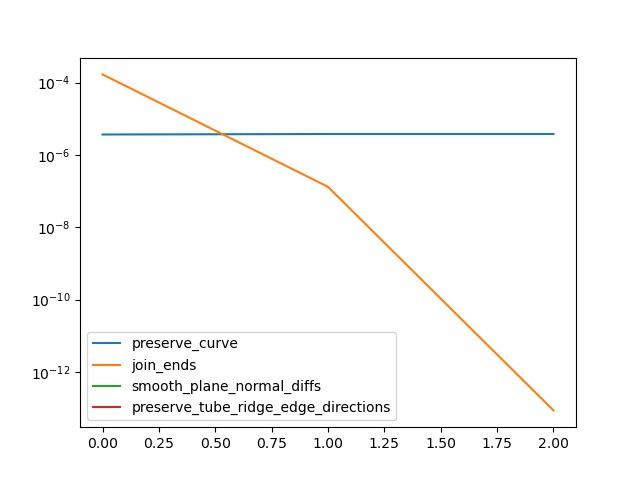

In [15]:
fig, ax = opt_prob.plot_objective_history()

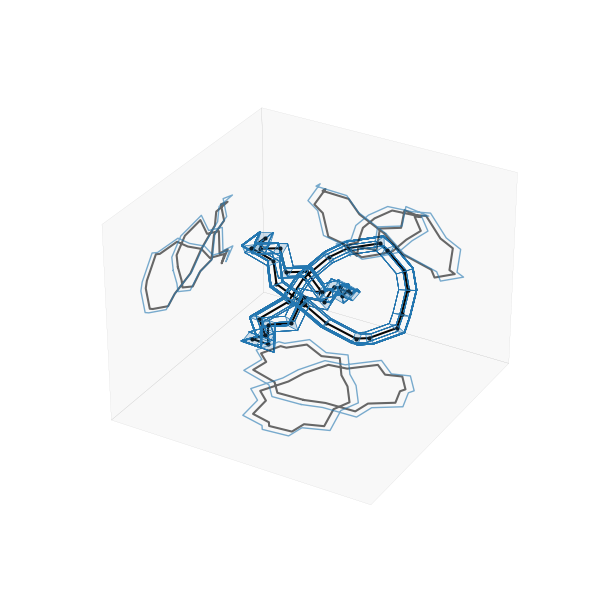

In [16]:
fig, ax = opt_prob.plot_3d()

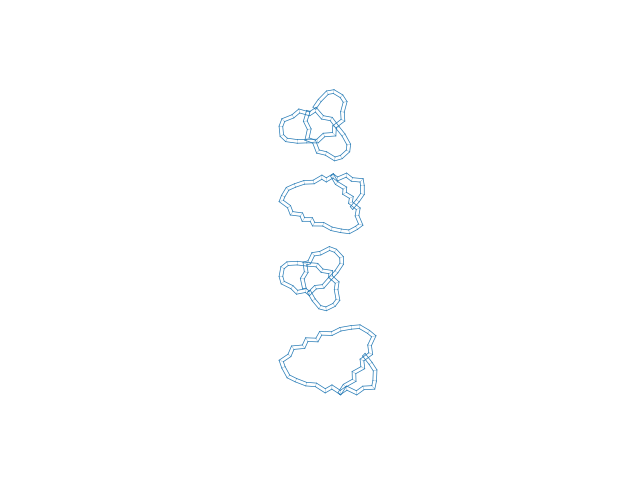

In [17]:
fig, ax = opt_prob.plot_unrolled_strips()